In [3]:
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches

from scipy.stats import gaussian_kde
from scipy.optimize import minimize_scalar

from numpy.polynomial.chebyshev import Chebyshev
import numpy as np

from rich.console import Console
from rich.table import Table

from multiprocessing import Pool, cpu_count

from iminuit import Minuit

import fastkde

import os

import constants, functions

In [4]:
def chi2(omega, sigma, gamma):
    model = functions.growth(constants.z_data, gamma=gamma, omega_0=omega, sigma_8_0=sigma)

    errors = np.asarray(0.5 * (constants.fs8_err_plus + constants.fs8_err_minus))
    residuals = (model - constants.fs8_data.values) / errors
    return np.sum(residuals**2)

n_om = 500
om_min = 0.01
om_max = 1.5

n_s8 = 500
s8_min = 0.1
s8_max = 1.6

n_gamma = 600
gamma_min = 0.1
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

minimizer = Minuit(chi2, omega=0.315, sigma=0.811, gamma=0.55)

minimizer.limits["omega"] = (om_min,om_max)
minimizer.limits["sigma"] = (s8_min,s8_max)
minimizer.limits["gamma"] = (gamma_min,gamma_max)

result = minimizer.migrad()

print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega']:.3f} ± {minimizer.errors['omega']:.4f}")
print(f"σ8,0 = {minimizer.values['sigma']:.3f} ± {minimizer.errors['sigma']:.4f}")
print(f"γ = {minimizer.values['gamma']:.3f} ± {minimizer.errors['gamma']:.3f}\n")

print(result)


Résultats du fit :
Chi2 = 8.69 

Paramètres estimés :
Ωm = 0.130 ± 0.0440
σ8,0 = 0.657 ± 0.0189
γ = 0.200 ± 0.186

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.691                      │              Nfcn = 191              │
│ EDM = 3.91e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴────────────

In [7]:
from joblib import Parallel, delayed

def chi2_om_sig8(omega, sigma, gamma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=gamma)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    minimizer.migrad()
    return minimizer.fval

chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_sig8)(omega, sigma, 0.55, gamma_min, gamma_max, chi2) for omega in omega_vals for sigma in sigma_vals)
    
chi2_grid = np.array(chi2_om_sig8).reshape(n_om, n_s8)

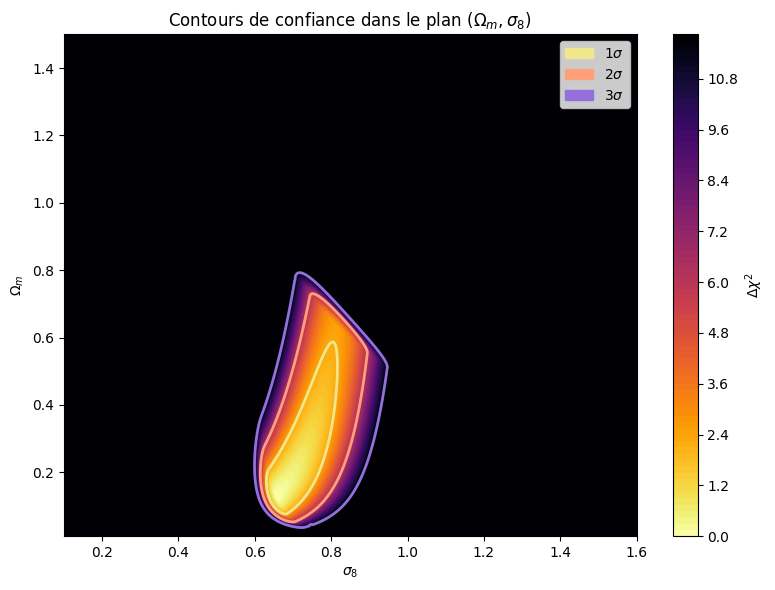

In [8]:
from matplotlib.patches import Patch

sigma_levels = [2.3, 6.17, 11.8]
colors = ['khaki', 'lightsalmon', 'mediumpurple']

X, Y = np.meshgrid(sigma_vals, omega_vals)
chi2_min = np.min(chi2_grid)
delta_chi2 = chi2_grid - chi2_min

delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=sigma_levels[2])

fig, ax = plt.subplots(figsize=(8, 6))

cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
for level, color in zip(sigma_levels, colors):
    cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

legend_handles = [
    Patch(color='khaki', label=r'$1\sigma$'),
    Patch(color='lightsalmon', label=r'$2\sigma$'),
    Patch(color='mediumpurple', label=r'$3\sigma$')
]
ax.legend(handles=legend_handles, loc='upper right')
ax.set_xlabel(r'$\sigma_8$')
ax.set_ylabel(r'$\Omega_m$')
ax.set_title(r'Contours de confiance dans le plan $(\Omega_m, \sigma_8)$')
ax.grid(False)

cbar = fig.colorbar(cf, ax=ax, label=r'$\Delta\chi^2$')

plt.tight_layout()
plt.show()